In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [75]:
rng = np.random.default_rng(0)

#algoritmo de la red neuronal hebb

def hebb_train_epochs(X, y, eta=1.0, epochs=1, shuffle=False, rng=None, average=False):
    if rng is None:
        rng = np.random.default_rng(0)
    Xb = np.hstack([np.ones((X.shape[0],1)), X])
    #w = np.zeros(Xb.shape[1])# recomendado 
    w = rng.random(Xb.shape[1])# punto 1 Aleatorio en [0,1)  (posible pero con sesgo positivo no deseado)

    acc_w = np.zeros_like(w)
    for e in range(epochs):
        idx = np.arange(len(y))
        if shuffle:
            rng.shuffle(idx)
        for i in idx:
            w += eta * y[i] * Xb[i]
        if average:
            acc_w += w
    return (acc_w/epochs) if average and epochs>0 else w

def augment_bias(X):
    return np.hstack([np.ones((X.shape[0],1)), X])

def to_pm1(col):
    if col.dtype == object:
        m = {"+1": 1.0, "-1": -1.0, "1": 1.0, "-1.0": -1.0, "1.0": 1.0}
        y = col.map(m).astype(float).to_numpy()
    else:
        y = col.astype(float).to_numpy()
    # Validación
    vals = set(np.unique(y))
    assert vals.issubset({-1.0, 1.0}), f"etiquetas inválidas: {vals}"
    return y

#explicar para primer punto 
def hebb_train(X, y, eta=1.0, w_init=None, shuffle=False, rng=None, return_init=False):
    if rng is None:
        rng = np.random.default_rng(0)
    Xb = augment_bias(X)
    d1 = Xb.shape[1]
    w = np.zeros(d1) if w_init is None else np.asarray(w_init, float).reshape(d1)
    w_in = w.copy()
    idx = np.arange(len(y))
    if shuffle:
        rng.shuffle(idx)
    for i in idx:
        w += eta * y[i] * Xb[i]
    return (w, w_in) if return_init else w


def hebb_predict(X, w):
    Xb = augment_bias(X)
    s = Xb @ w
    yhat = np.where(s>=0, 1.0, -1.0)
    return yhat, s

In [76]:
# Debe existir 'datos.csv' con columnas: x1, x2, x3, clase
#se leen los datos de entrada especificados en el documento 
df = pd.read_csv("datos_petroleo.csv")
X = df[["x1","x2","x3"]].to_numpy(dtype=float)   # (N,3)
y = to_pm1(df["D"])                           # (N,)
print(X.shape, y.shape, np.unique(y, return_counts=True))

(30, 3) (30,) (array([-1.,  1.]), array([14, 16]))


In [77]:
rng = np.random.default_rng(0)
N = len(y)
idx = rng.permutation(N)
p = int(0.8 * N)

itr, ite = idx[:p], idx[p:]
Xtr, Xte = X[itr], X[ite]
ytr, yte = y[itr], y[ite]

print("train:", Xtr.shape, "test:", Xte.shape)

train: (24, 3) test: (6, 3)


In [78]:
# Ajuste en TRAIN normaniza, estandariza datos 
mu = Xtr.mean(axis=0)
sigma = Xtr.std(axis=0)
sigma[sigma == 0] = 1.0  # evita división por cero

# Transformación
Xtr_std = (Xtr - mu) / sigma
Xte_std = (Xte - mu) / sigma

In [80]:
def confusion(y_true, y_pred):
    from collections import Counter
    c = Counter(zip(y_true.astype(int), y_pred.astype(int)))
    tp = c[(1,1)]; tn = c[(-1,-1)]
    fp = c[(-1,1)]; fn = c[(1,-1)]
    return dict(c), tp, tn, fp, fn

# Train
yhat_tr, s_tr = hebb_predict(Xtr, w)
acc_tr = (yhat_tr == ytr).mean()
cm_tr, tp, tn, fp, fn = confusion(ytr, yhat_tr)
prec_pos = tp/(tp+fp) if (tp+fp)>0 else 0.0
rec_pos  = tp/(tp+fn) if (tp+fn)>0 else 0.0

# Test
yhat_te, s_te = hebb_predict(Xte, w)
acc_te = (yhat_te == yte).mean()
cm_te, TP, TN, FP, FN = confusion(yte, yhat_te)
prec_pos_te = TP/(TP+FP) if (TP+FP)>0 else 0.0
rec_pos_te  = TP/(TP+FN) if (TP+FN)>0 else 0.0

print(f"Train acc: {acc_tr:.3f} | Prec(+1): {prec_pos:.3f} | Rec(+1): {rec_pos:.3f}")
print("Matriz confusión train {(y,ŷ):conteo}:", cm_tr)
print(f"Test  acc: {acc_te:.3f} | Prec(+1): {prec_pos_te:.3f} | Rec(+1): {rec_pos_te:.3f}")
print("Matriz confusión test  {(y,ŷ):conteo}:", cm_te)

Train acc: 0.500 | Prec(+1): 0.000 | Rec(+1): 0.000
Matriz confusión train {(y,ŷ):conteo}: {(-1, -1): 12, (1, -1): 12}
Test  acc: 0.333 | Prec(+1): 0.000 | Rec(+1): 0.000
Matriz confusión test  {(y,ŷ):conteo}: {(1, -1): 4, (-1, -1): 2}


In [81]:
X_new = np.array([

[-0.3565, 0.0620, 5.9891],
[-0.7842, 1.1267, 5.5912],
[0.3012, 0.5611, 5.8234],
[0.7757, 1.0648, 8.0677],
[0.1570, 0.8028, 6.3040],
[-0.7014, 1.0316, 3.6005],
[0.3748, 0.1536, 6.1537],
[-0.6920, 0.9404, 4.4058],
[-1.3970, 0.7141, 4.9263],
[-1.8842, -0.2805, 1.2548]

    
], dtype=float)

y_new, s_new = hebb_predict(X_new, w)

X_new_std = (X_new - mu) / sigma
y_new, s_new = hebb_predict(X_new_std, w)

print("ŷ nuevos:", y_new.astype(int))
print("scores:", s_new)  # distancia firmada al hiperplano

ŷ nuevos: [-1  1  1  1  1  1 -1  1  1  1]
scores: [-5.48203294 33.86583121  6.90861864  9.44427544 13.49682426 39.52194811
 -8.35872712 32.73221647 27.853994   16.16912192]


In [82]:

def plot_2d_boundary(X, y, w, feat_idx=(0,1), fixed=None, title="Hebb 2D"):
    """
    X: (N,3) o (N,d)
    y: {-1,+1}
    w: (d+1,) con sesgo
    feat_idx: pareja de features a mostrar, ej (0,1)->(x1,x2)
    fixed: dict para fijar las otras features, ej {2:0.0}
           Si None: fija a la media de X para las omitidas.
           Si trabajaste con estandarización: usa {k:0.0} para omitidas.
    """
    d = X.shape[1]
    fs = list(feat_idx)
    omitidas = [k for k in range(d) if k not in fs]

    if fixed is None:
        fixed = {k: float(X[:,k].mean()) for k in omitidas}
    else:
        fixed = {int(k): float(v) for k,v in fixed.items()}

    # Sesgo efectivo al “colapsar” dimensiones omitidas
    b_eff = w[0] + sum(w[k+1]*fixed.get(k, 0.0) for k in omitidas)
    i, j = fs

    xi = X[:, i]; xj = X[:, j]
    plt.figure()
    plt.scatter(xi[y==1],  xj[y==1],  label="+1")
    plt.scatter(xi[y==-1], xj[y==-1], label="-1")

    # Línea: w_i * xi + w_j * xj + b_eff = 0  => xj = -(b_eff + w_i*xi)/w_j
    wi, wj = w[i+1], w[j+1]
    if abs(wj) > 1e-12:
        xs = np.linspace(xi.min()-0.5, xi.max()+0.5, 300)
        ys = -(b_eff + wi*xs)/wj
        plt.plot(xs, ys, label="frontera")
    plt.xlabel(f"x{1+i}"); plt.ylabel(f"x{1+j}")
    plt.title(title); plt.legend(); plt.show()

In [83]:
def plot_3d_plane(X, y, w, title="Hebb 3D"):
    """
    Grafica puntos y el plano w0 + w1*x1 + w2*x2 + w3*x3 = 0
    Solo para d==3.
    """
    assert X.shape[1] == 3, "Necesita 3 features."
    x1, x2, x3 = X[:,0], X[:,1], X[:,2]
    w0, w1, w2, w3 = w
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x1[y==1],  x2[y==1],  x3[y==1],  label="+1")
    ax.scatter(x1[y==-1], x2[y==-1], x3[y==-1], label="-1")

    # Plano: x3 = -(w0 + w1*x1 + w2*x2)/w3 si w3 != 0
    if abs(w3) > 1e-12:
        x1g = np.linspace(x1.min()-0.5, x1.max()+0.5, 30)
        x2g = np.linspace(x2.min()-0.5, x2.max()+0.5, 30)
        X1g, X2g = np.meshgrid(x1g, x2g)
        X3g = -(w0 + w1*X1g + w2*X2g)/w3
        ax.plot_surface(X1g, X2g, X3g, alpha=0.3)
    ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.set_zlabel("x3")
    ax.set_title(title); ax.legend(); plt.show()

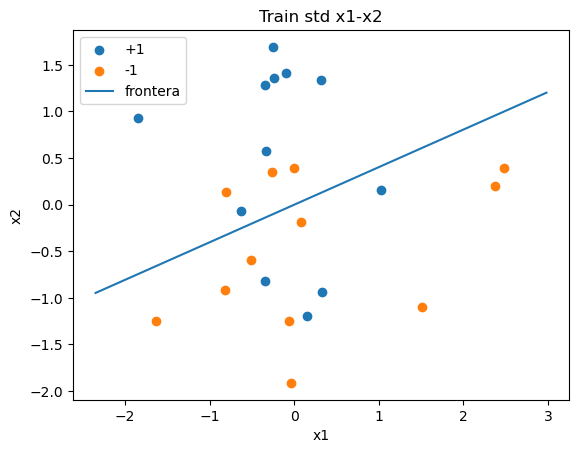

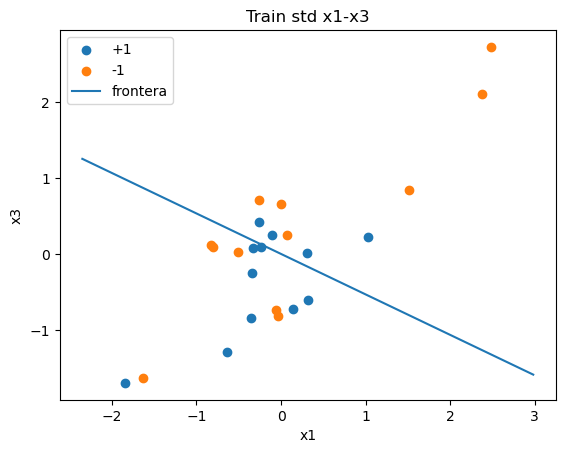

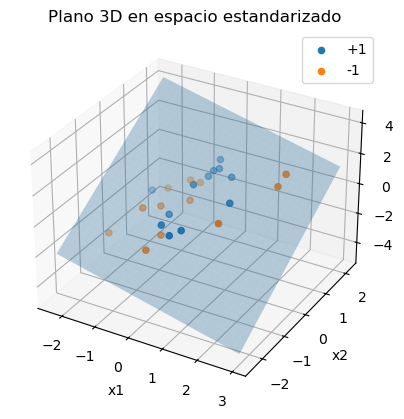

In [84]:
# Usa los arrays estandarizados (Xtr_std, Xte_std) y w entrenado en ellos.
plot_2d_boundary(Xtr_std, ytr, w, feat_idx=(0,1), fixed={2:0.0}, title="Train std x1-x2")
plot_2d_boundary(Xtr_std, ytr, w, feat_idx=(0,2), fixed={1:0.0}, title="Train std x1-x3")
plot_3d_plane(Xtr_std, ytr, w, title="Plano 3D en espacio estandarizado")

In [87]:
# X: (N,3), y: {-1,+1}
#punto 2 
rng = np.random.default_rng(123)#aqui define la aletoreidad del primer punto 
for k in range(5):
    w_init = rng.random(4)  # (w0,w1,w2,w3) en [0,1) valores aleatorios para cada entrenamiento como lo indica el punto 1 
    w_out, w_in = hebb_train(X, y, eta=1.0, w_init=w_init, shuffle=True, rng=rng, return_init=True)
    print(f"Caso {k+1}:")
    print("  w_in  =", np.round(w_in, 4))#para registrar en la tabla del punto 2  
    print("  w_out =", np.round(w_out, 4)) #para registrar en la tabla del punto 2 
#aqui salen los vectores del punto 2, el numero de epocas es 1

Caso 1:
  w_in  = [0.6824 0.0538 0.2204 0.1844]
  w_out = [ 2.6824 -0.5359  6.4044 -1.6118]
Caso 2:
  w_in  = [0.4978 0.5827 0.1843 0.0149]
  w_out = [ 2.4978 -0.007   6.3683 -1.7813]
Caso 3:
  w_in  = [0.4683 0.1277 0.2576 0.0032]
  w_out = [ 2.4683 -0.462   6.4416 -1.793 ]
Caso 4:
  w_in  = [0.5788 0.0704 0.4884 0.6101]
  w_out = [ 2.5788 -0.5193  6.6724 -1.1861]
Caso 5:
  w_in  = [0.1515 0.8733 0.1791 0.0303]
  w_out = [ 2.1515  0.2836  6.3631 -1.7659]


In [61]:
# todo se hace con una sola iteracion!!
#No hay “épocas” en Hebb puro. Se hace una pasada por los 𝑁 N patrones y listo. Repetir pasadas solo escala  𝑤 w, no cambia la frontera si la decisión es sign


### Cuándo importan las épocas

- En algoritmos guiados por error (perceptrón, descenso de gradiente).
- En variantes con normalización o decaimiento (p. ej. Oja).
- Si haces promedio de épocas para estabilidad numérica.

In [72]:
#tercer punto 
#cada elemento de y_hat corresponde a una muestra (1 a 10) y cada fila del dataframe corresponde a y(t1) y(t2) ... 
rng = np.random.default_rng(123)
res = []
for k in range(5):
    w_init = rng.random(X.shape[1] + 1)          # (w0..w3) en [0,1)
    w_out, w_in = hebb_train(X, y, eta=1.0, w_init=w_init, shuffle=True, rng=rng, return_init=True)
    y_hat, s = hebb_predict(X_new_std, w_out)
    res.append({
        "run": k+1,
        "w_in": np.round(w_in, 4),
        "w_out": np.round(w_out, 4),
        "y_hat": y_hat.astype(int),
        "scores": np.round(s, 4)
    })

pd.DataFrame(res)#para registrar en la tabla del punto 3 

,run,w_in,w_out,y_hat,scores
0,1,"[0.6824, 0.0538, 0.2204, 0.1844]","[2.6824, -0.5359, 6.4044, -1.6118]","[-1, 1, 1, 1, 1, 1, -1, 1, 1, -1]","[-4.6122, 15.3697, 4.0454, 10.8358, 8.1224, 15..."
1,2,"[0.4978, 0.5827, 0.1843, 0.0149]","[2.4978, -0.007, 6.3683, -1.7813]","[-1, 1, 1, 1, 1, 1, -1, 1, 1, -1]","[-5.2808, 14.289, 3.8639, 10.7746, 7.7577, 14...."
2,3,"[0.4683, 0.1277, 0.2576, 0.0032]","[2.4683, -0.462, 6.4416, -1.793]","[-1, 1, 1, 1, 1, 1, -1, 1, 1, -1]","[-4.8642, 15.2212, 3.9352, 10.6116, 7.9746, 15..."
3,4,"[0.5788, 0.0704, 0.4884, 0.6101]","[2.5788, -0.5193, 6.6724, -1.1861]","[-1, 1, 1, 1, 1, 1, -1, 1, 1, -1]","[-5.3424, 15.3446, 3.6719, 11.3721, 8.0391, 14..."
4,5,"[0.1515, 0.8733, 0.1791, 0.0303]","[2.1515, 0.2836, 6.3631, -1.7659]","[-1, 1, 1, 1, 1, 1, -1, 1, 1, -1]","[-5.9736, 13.3904, 3.4496, 10.5788, 7.2808, 13..."
